In [23]:
from IPython.display import clear_output
import matplotlib.backends.backend_pdf
from tqdm.notebook import tqdm
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
import scvelo as scv
scv.settings.verbosity=1
import sys
sys.path.insert(1, '../')
from util_fcts import *

# Diffusion Analysis

In [2]:
adata = sc.read("/fast/work/users/peidlis_c/data/Cov19Hamster/PhoRob_DexAb/DexAb_combined_integrated_loomed_preprocessed_Neutrophils_Neutrophils.h5")

In [3]:
adata.obs.condition = adata.obs.condition.cat.rename_categories({'Untr': 'mock', 'ab': 'mAb', 'dex': 'Dex', 'dexab': 'Dex + mAb'})
# adata.uns['condition_colors'] = ['#373535', '#a1a0a3', '#282e69', '#6599d2']
adata.uns['condition_colors'] = ['#282e69', '#6599d2', '#a1a0a3', '#373535']  # reordered

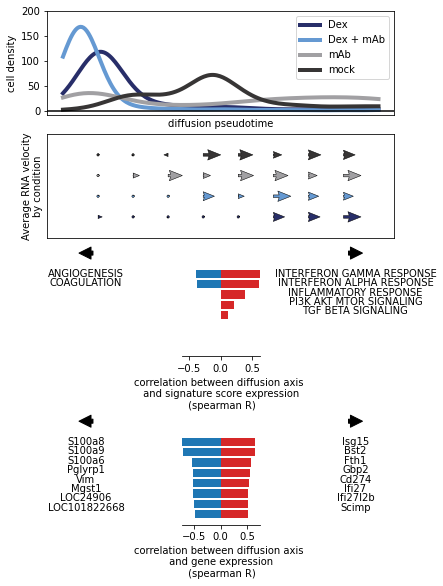

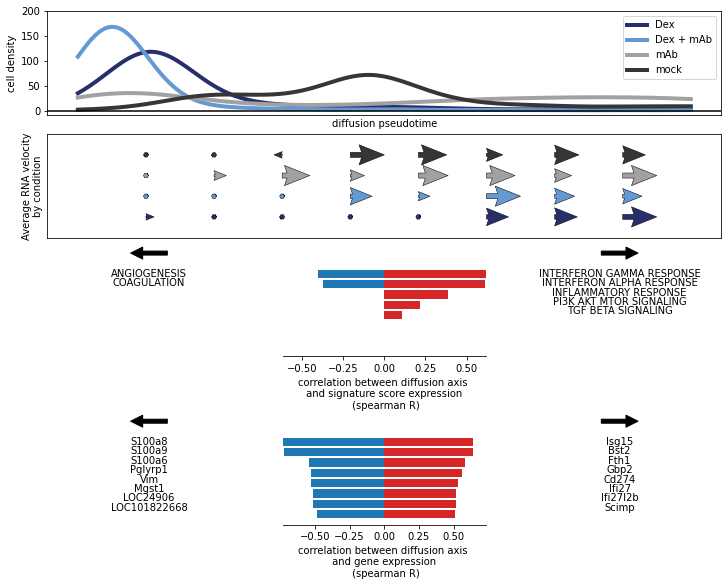

In [5]:
diffusion_analysis_(adata, 'condition', species='mouse', component=1, corr_cutoff=0.1, figsize=[6,8], range_percs=[5,95], velocity_mode='average', show=False)
pl.savefig('../figures/main_figure_raw.pdf')
pl.show()
diffusion_analysis_(adata, 'condition', species='mouse', component=1, corr_cutoff=0.1, figsize=[10,8], range_percs=[5,95], velocity_mode='average', show=False)
pl.savefig('../figures/main_figure_wide_raw.pdf')
pl.show()

# arrows on umap embedding in the paper

In [231]:
adata = sc.read("../data/DexAb_combined_integrated_loomed_preprocessed_Neutrophils_Neutrophils.h5")

In [232]:
# add newest embedding (used in paper)
tab = pd.read_csv('../metadata/seurat_umap_new.csv', index_col=0)
adata = adata[np.isin(adata.obs_names, tab.index)].copy()
adata.obsm['X_umap_new'] = tab.loc[adata.obs_names].values

In [233]:
# project RNA velocities into new embedding using cosine similarity
scv.tl.velocity_embedding(adata, basis='umap_new')

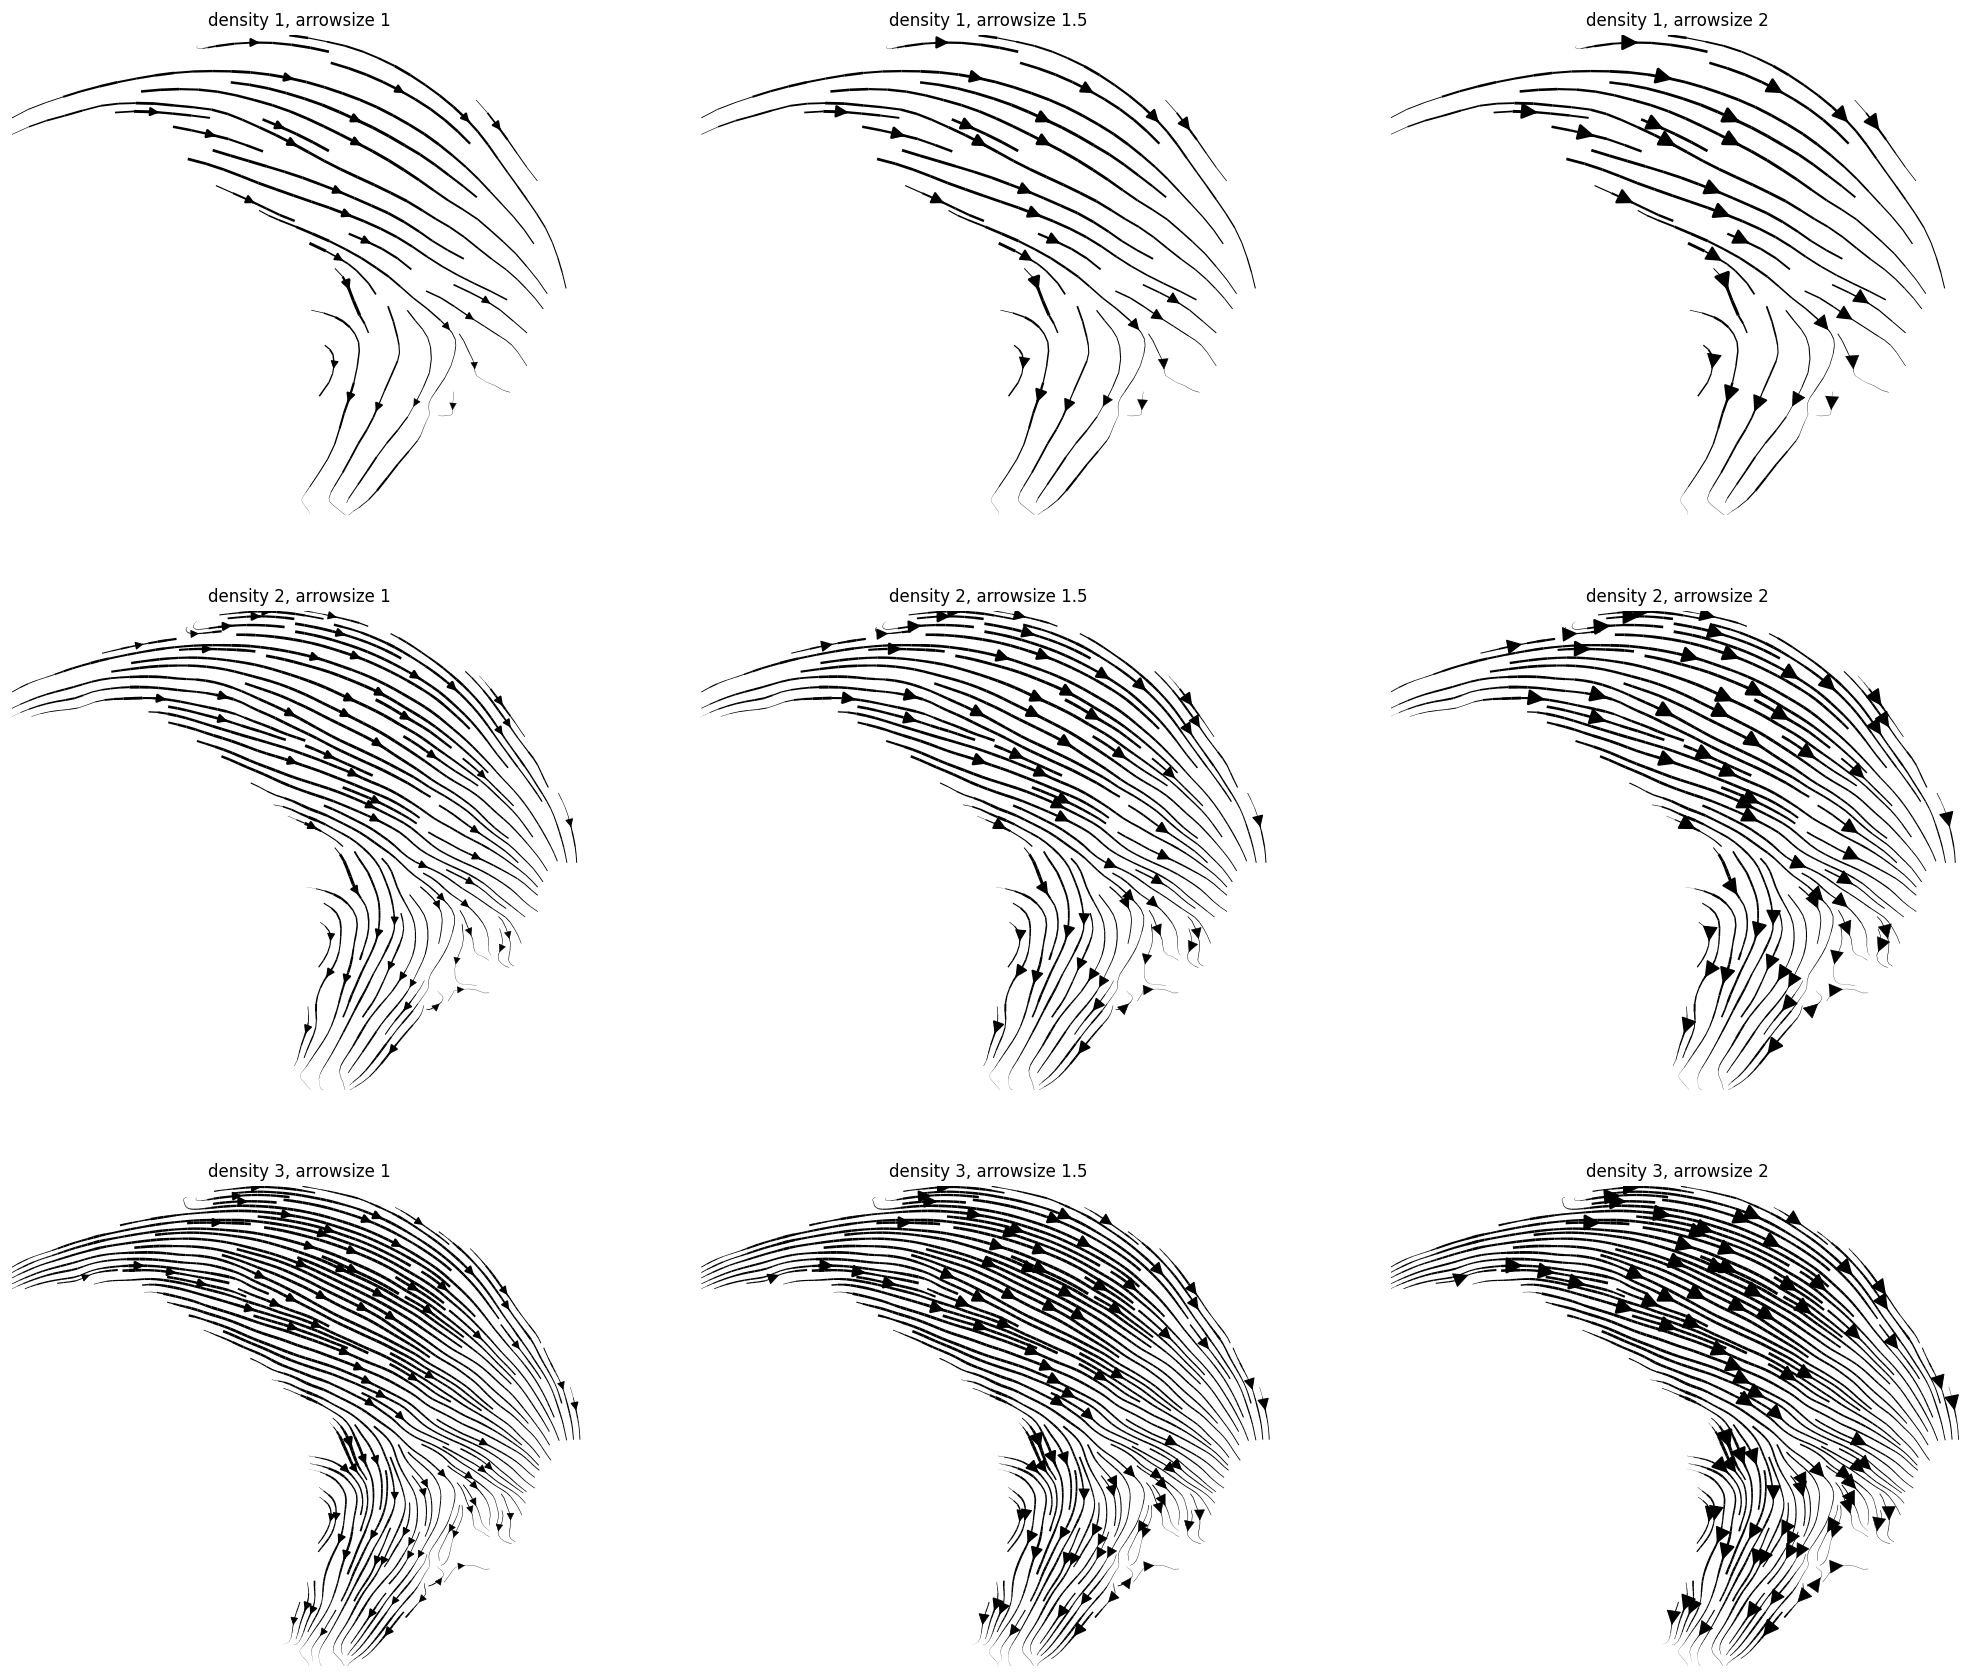

In [80]:
# plot with transparent packground so we can use it as add-on to existing plots
fig, axss = pl.subplots(3,3, dpi=120, figsize=[7*3,6*3])
for i, density in enumerate([1,2,3]):
    for j, arrow_size in enumerate([1,1.5,2]):
        scv.pl.velocity_embedding_stream(adata, basis='umap_new', alpha=0, size=0, legend_loc=False, dpi=120, figsize=[7,6], show=False, ax=axss[i][j],
                                         title=f'density {str(density)}, arrowsize {str(arrow_size)}', arrow_size=arrow_size, density=density)
pl.savefig('../figures/velocity_streams_transparent.png')
pl.show()

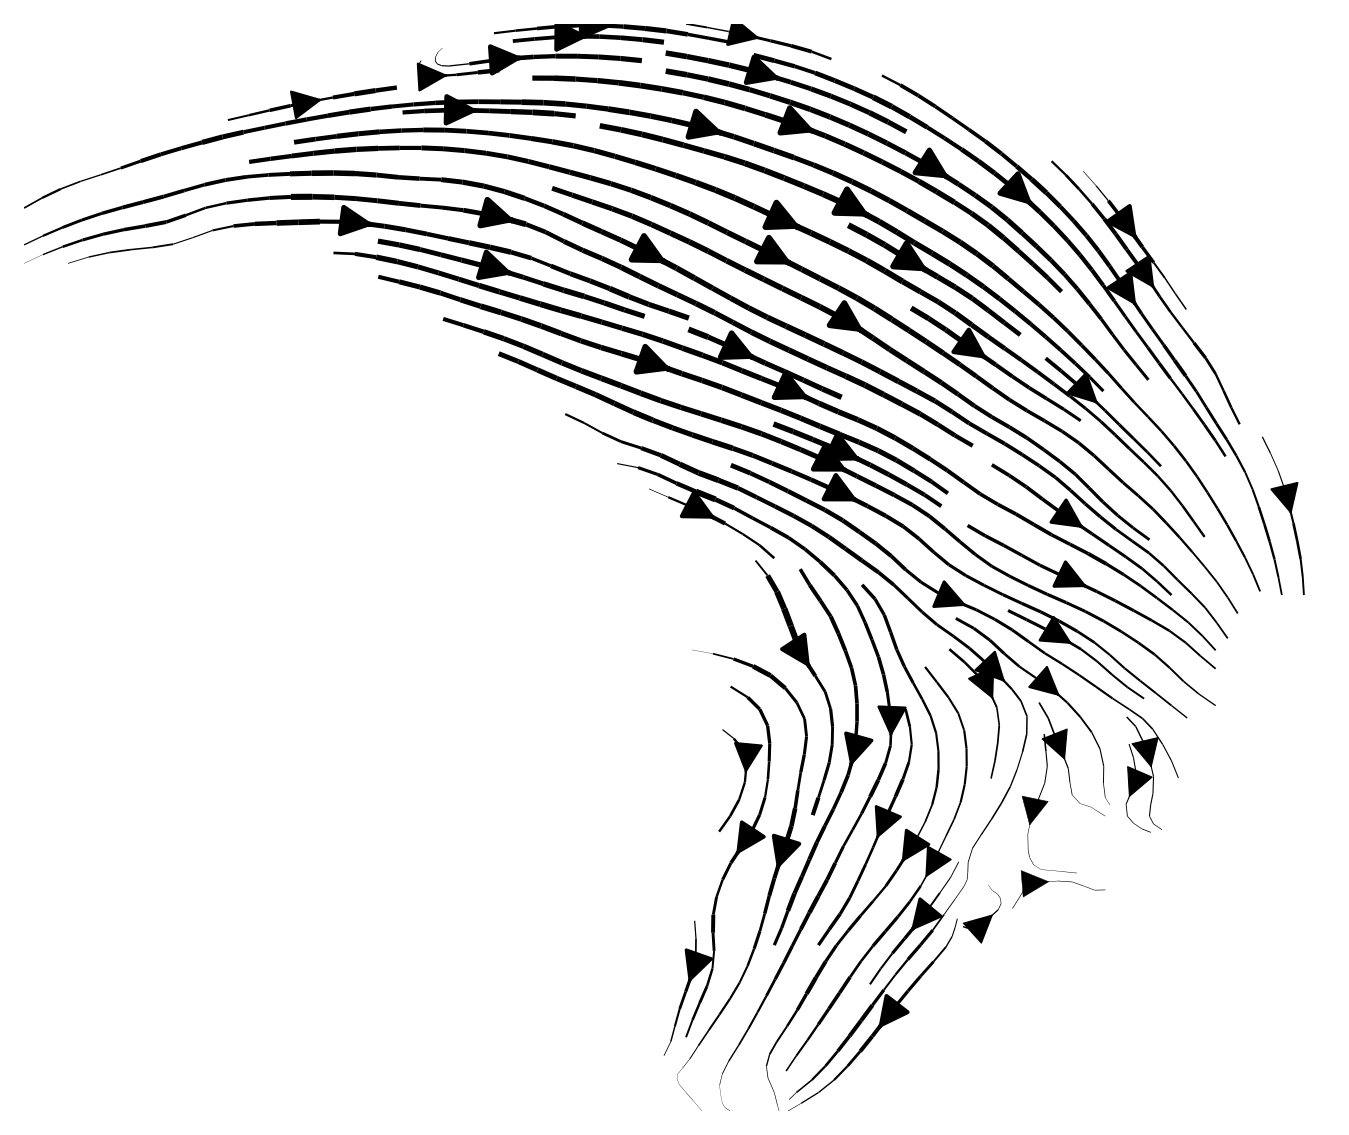

In [236]:
# plot with transparent packground so we can use it as add-on to existing plots
scv.pl.velocity_embedding_stream(adata, basis='umap_new', alpha=0, size=0, legend_loc=False, dpi=240, figsize=[7,6], show=False,
                                         title='', arrow_size=2, density=2)
pl.savefig('../figures/velocity_streams_transparent_special_selection.png')
pl.show()

# Custom embeddings with velocity

In [107]:
adata = sc.read("../data/DexAb_combined_integrated_loomed_preprocessed_Neutrophils_Neutrophils.h5")
adata.obs.condition = adata.obs.condition.cat.rename_categories({'Untr': 'mock', 'ab': 'mAb', 'dex': 'Dex', 'dexab': 'Dex + mAb'})
adata.uns['condition_colors'] = ['#373535', '#a1a0a3', '#282e69', '#6599d2']
adata.obs['has_viral'] = adata.obs.SCoV2_sum>0
adata = adata[np.random.permutation(adata.n_obs)].copy()  # shuffle for scatter

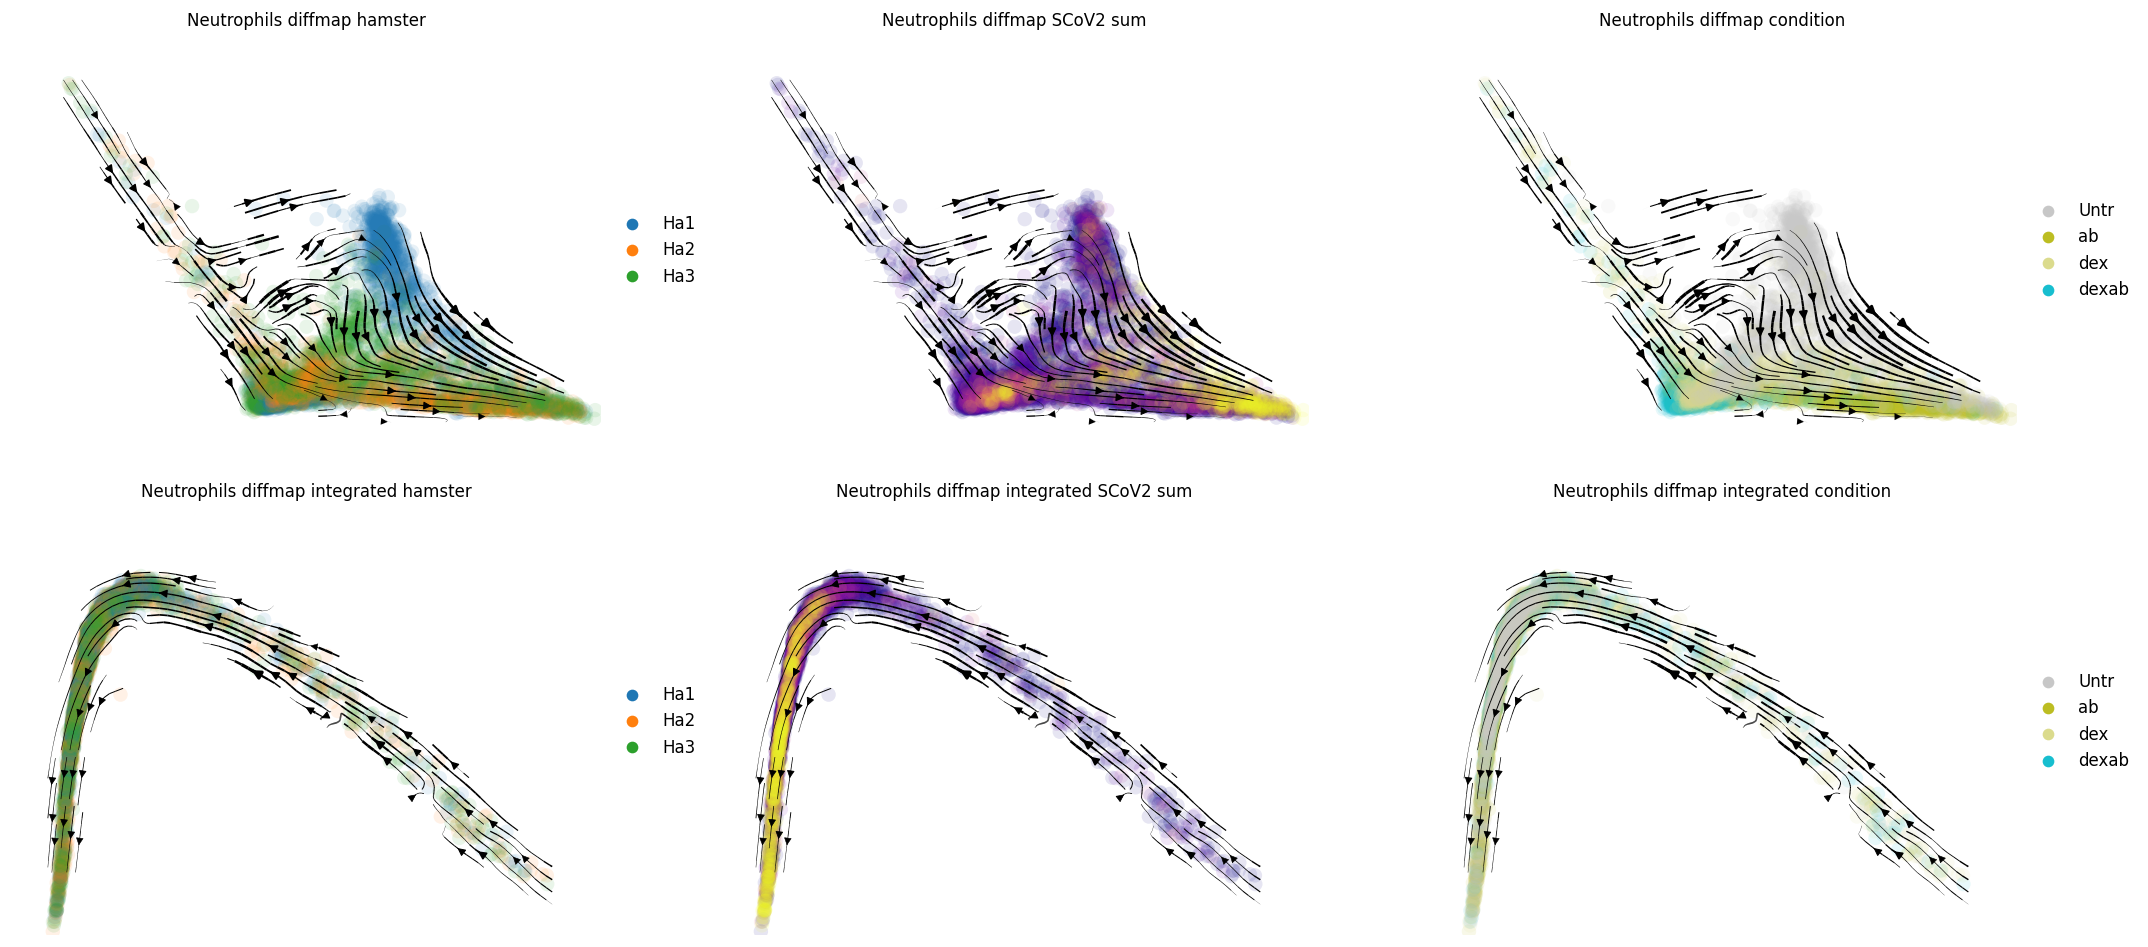

In [266]:
basis = ['diffmap', 'diffmap_integrated']  # my umap is ugly, integrated looks like seurat umap, which we alread show in the main figure.
color=['hamster', 'SCoV2_sum', 'condition']
fig, axss = pl.subplots(len(basis), len(color), figsize=[6*len(color), 4*len(basis)], dpi=120)
for axs, b in zip(axss, basis):
    for ax, c in zip(axs, color):
        scv.pl.velocity_embedding_stream(adata, color=c, basis=b, figsize=[8,6], components='1,2', perc=[5,95], ax=ax,
                                 legend_loc='right margin', alpha=0.1, size=300, min_mass=2, dpi=120, density=2, show=False, 
                                         title=f'Neutrophils {b} {c}', cmap='plasma', colorbar=False);
pl.tight_layout()
pl.savefig('../figures/Supplement_velocity_embeddings.png')
pl.show()

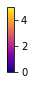

In [275]:
scv.pl.scatter(adata, color=color[1], perc=[5,95], cmap='plasma', show=False, alpha=0)
fig = pl.gcf()
fig.axes[0].remove()
pl.savefig('../figures/colorbar_plasma_extra.pdf')


## Deprecated Figure (ugly)

In [228]:
x = adata.obsm['X_diffmap'][:,1].T
y = adata.obsm['X_diffmap'][:,2].T
c = adata.obs.condition.values
xmin = np.percentile(x, 5)
xmax = np.percentile(x, 95)

df = pd.DataFrame([x, y, c]).T
df.columns = ['x', 'y', 'condition']
mask = (df.x>xmin)&(df.x<xmax)
df = df[mask]

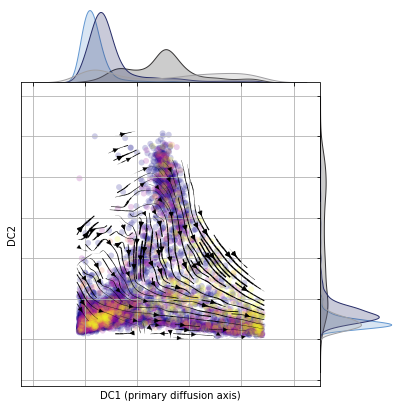

In [219]:
jp = sns.jointplot(data=df, x="x", y="y", hue="condition", palette=dict(zip(c.categories, list(adata.uns['condition_colors']))), alpha=0, ratio=4, space=0, legend=False)
scv.pl.velocity_embedding_stream(adata[mask].copy(), basis='diffmap', alpha=0.2, color='SCoV2_sum', 
                                 legend_loc=False, show=False, ax=jp.ax_joint, title='', density=1.5, frameon=True, perc=[5,95], cmap='plasma', colorbar=False)
# jp.ax_marg_x.set_xticks([])
# jp.ax_marg_y.set_xticks([])
jp.ax_joint.set_xlabel('DC1 (primary diffusion axis)')
jp.ax_joint.grid(True)
pl.show()

# Prepare loom for GEO upload

This loom is basically just an annotated, merged version of the velocyto output looms. No normalization or filtering applied.

In [92]:
adata = sc.read("/fast/work/users/peidlis_c/data/Cov19Hamster/PhoRob_DexAb/DexAb_combined_integrated_loomed.h5")

In [86]:
adata

AnnData object with n_obs × n_vars = 43174 × 18035
    obs: 'origin', 'sample_id', 'condition_id', 'condition', 'dex', 'ab', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'seurat_clusters', 'SCoV2_sum', 'SCoV2_load', 'UMAP_1', 'UMAP_2', 'treatment', 'hamster', 'integrated_snn_res.1', 'celltype'
    obsm: 'X_pca_seurat', 'X_umap_seurat'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [97]:
# only select relevant entries
bdata = sc.AnnData(X=adata.X, obs=adata.obs[['treatment', 'hamster', 'celltype', 'SCoV2_sum', 'SCoV2_load']], var=adata.var)
bdata.layers['spliced'] = adata.layers['spliced']
bdata.layers['ambiguous'] = adata.layers['ambiguous']
bdata.layers['unspliced'] = adata.layers['unspliced']

In [98]:
bdata.write_loom("/fast/work/users/peidlis_c/data/Cov19Hamster/PhoRob_DexAb/DexAb.loom")